# In this notebook
I explore mol2vec to see if I can extract information from these learned embeddings.

In [13]:
import pandas as pd

from mol2vec import features
from mol2vec.features import mol2sentence
from mol2vec.features import sentences2vec
from rdkit import Chem

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from gensim.models import word2vec

In [2]:
# Read in the data.
df = pd.read_csv('./data/clean_henrys.csv', index_col=0)

In [3]:
smiles = df['canonical_smiles']

chemicals = [Chem.MolFromSmiles(s) for s in smiles]
sentences = [mol2sentence(c, 1)[1] for c in chemicals]

In [4]:
# So now we have a list of sentences that depicts the identifiers
# for all radii combined. Note that this is a simpler representation
# Let's look at an individual sentence
sentences[0]

['2246728737',
 '392737424',
 '3388977530',
 '2546348154',
 '2246728737',
 '392737424',
 '2246728737',
 '392737424',
 '864662311',
 '390582892']

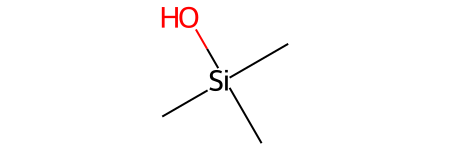

In [5]:
chemicals[0]

In [15]:
m = Chem.MolFromSmiles('c1ccccc1')

In [19]:
for atom in m.GetAtoms():
    print(atom.GetBonds()[0])

In [32]:
for b in m.GetBonds():
    print(b.GetBondType())

AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC


In [4]:
# Load in the model that was pretrained on
model = word2vec.Word2Vec.load('./models/model_300dim.pkl')

In [13]:
model.wv.get_vector(sentences[0][0])

array([-0.13674529,  0.06729241, -0.05213054, -0.00750703,  0.28921816,
       -0.13024387, -0.18778022, -0.08180202,  0.17663261, -0.23623651,
        0.15215029,  0.03104335,  0.22715245, -0.00406356,  0.0321878 ,
       -0.14886402,  0.35155123,  0.05230371,  0.25634497,  0.14891872,
       -0.0038601 ,  0.16931136,  0.31372482,  0.01881147, -0.19952172,
        0.03404459, -0.04627627, -0.21893106,  0.12341108,  0.05439068,
        0.05448844, -0.04903906, -0.31361288, -0.33548406, -0.04213666,
       -0.14339392, -0.0289033 , -0.0923715 ,  0.18249372,  0.1544386 ,
       -0.09051799,  0.07533539, -0.01364344, -0.17796858, -0.06144299,
       -0.00402305, -0.10959177,  0.09328562, -0.08955006,  0.15117231,
        0.12398589, -0.20872705,  0.3017063 , -0.16636986, -0.26913744,
       -0.12916061, -0.15348934,  0.11056198, -0.02592117, -0.06371941,
       -0.19357003,  0.00200986, -0.05617516,  0.0011254 , -0.5563765 ,
        0.04836231, -0.00086217,  0.08364478, -0.30566263,  0.05

**Let's combine the word vectors for each sentence**

In [5]:
import numpy as np

X = []
y = []

# Define the allowable number of molecules missing
missing_threshold = 0.2

throwout_num = 0
for sentence, hv in zip(sentences, df['value']):
    sentence_vec = []
    missing = 0
    for w in sentence:
        try:
            vec = model.wv.get_vector(w)
            sentence_vec.append(vec)
        except:
            missing += 1
    
    if missing/len(sentence) > missing_threshold:
        throwout_num += 1
        continue
    
    sv = np.array(sentence_vec).sum(axis=0)
    X.append(list(sv))
    y.append(hv)

In [6]:
print("There are %s molecules left over." % len(y))

There are 927 molecules left over.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
y_test = np.log10(y_test)
y_train = np.log10(y_train)

# Let's try K Nearest Neighbors Regressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [11]:
clf = KNeighborsRegressor(n_neighbors=8)

clf.fit(X_train, y_train)

mse = mean_squared_error(y_test, clf.predict(X_test))
print(mse)
preds = clf.predict(X_test)

2.4919475320753723


Text(0.5, 0, 'Predicted')

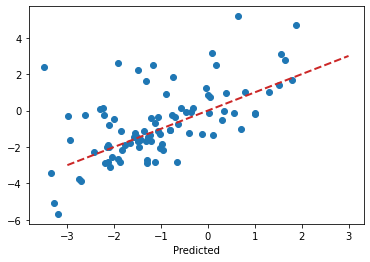

In [14]:
plt.scatter(preds, y_test)
perfect = np.linspace(-3, 3, 100)
plt.plot(perfect, perfect, '--', color="#cc2727", linewidth=2)
plt.xlabel("Predicted")

In [31]:
clf = Lasso(alpha=.06, max_iter=2000)

clf.fit(X_train, y_train)

mean_squared_error(y_test, clf.predict(X_test))

1.314787828221836

In [32]:
preds = clf.predict(X_test)

Text(0.5, 0, 'Predicted')

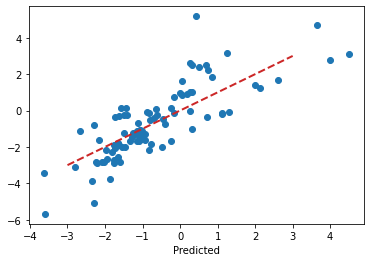

In [33]:
plt.scatter(preds, y_test)
perfect = np.linspace(-3, 3, 100)
plt.plot(perfect, perfect, '--', color="#cc2727", linewidth=2)
plt.xlabel("Predicted")

In [17]:
clf = RandomForestRegressor(n_estimators=500, max_depth=5)

clf.fit(X_train, y_train)

mean_squared_error(y_test, clf.predict(X_test))

2.347924440031377

Well darn...performance is not looking as good as I would hope. If I were to guess, we have too many components...let's see if we can reduce dimensionality using PCA.

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=300)

pca.fit(X_train)

PCA(n_components=300)

Text(0.5, 1.0, 'Principal Components')

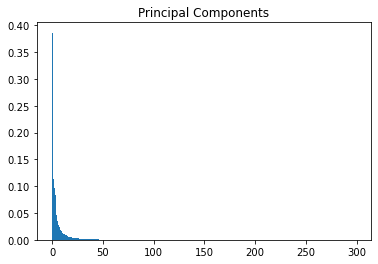

In [20]:
plt.bar(range(0,300), pca.explained_variance_ratio_)
plt.title("Principal Components")

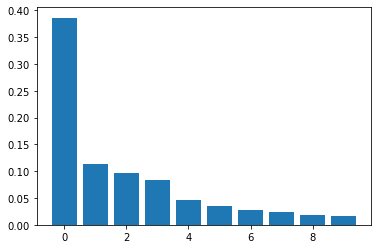

In [21]:
plt.bar(range(0, 10), pca.explained_variance_ratio_[0:10])
plt.show()

So, if we just look at the top 5 principal components, we can drastically reduce the dimensionality of this problem...and likely boost performance, too.

In [96]:
clf = RandomForestRegressor(n_estimators=500, max_depth=10)
pca = PCA(n_components=5)
x_train_pc = pca.fit_transform(X_train)
x_test_pc = pca.transform(X_test)

clf.fit(x_train_pc, y_train)

mean_squared_error(y_test, clf.predict(x_test_pc))

2.3261987561018396

In [111]:
clf = KNeighborsRegressor(n_neighbors=15)

clf.fit(x_train_pc, y_train)

mse = mean_squared_error(y_test, clf.predict(x_test_pc))
print(mse)
preds = clf.predict(x_test_pc)

2.237125267064516


In [27]:
clf = Lasso(alpha=.0001, max_iter=2000)

pca = PCA(n_components=5)
x_train_pc = pca.fit_transform(X_train)
x_test_pc = pca.transform(X_test)

clf.fit(x_train_pc, y_train)

mean_squared_error(y_test, clf.predict(x_test_pc))

3.6438829218970765

Well darn...looks like we still can't tell the difference using 5 components. Let's extend to 10 components.

In [28]:
pca = PCA(n_components=200)
x_train_pc = pca.fit_transform(X_train)
x_test_pc = pca.transform(X_test)

In [29]:
clf = KNeighborsRegressor(n_neighbors=10)

clf.fit(x_train_pc, y_train)

mse = mean_squared_error(y_test, clf.predict(x_test_pc))
print(mse)
preds = clf.predict(x_test_pc)

2.5344281035662735


Well, it looks like this isn't working any better. If I were to guess, the components

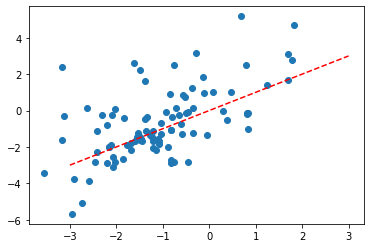

In [30]:
plt.scatter(preds, y_test)
perfect = np.linspace(-3, 3, 100)
plt.plot(perfect, perfect, '--', color='red')
plt.show()

Where to go next?
* Seems like my method of combining structures isn't necessarily correct.
* Need to figure out this radius thing to see if I'm using words correctly.

Once I answer the questions above, I'm going to try to see if I can use count vectors to get a model out.

Lastly, I'll look into graph neural networks as a potential option, although I doubt I have enough data to truly learn a good model...